# Cognossementen in de *Dutch Prize Papers*: een algoritmische verkenning

Gerhard de Kok

Oorlog is *business*. Dat gold vroeger net als nu, hoewel niet altijd op dezelfde manier. Tot in de negentiende eeuw was kaapvaart een valide manier van oorlogvoering op zee. Voorzien van een kaperbrief zochten kapiteins van kaperschepen op zee naar particuliere schepen onder de vlag van de vijand. Ook neutrale schepen die goederen van een vijand vervoerden beschouwden de Britten als valide buit. Bij een verovering kwam een deel van de opbrengst van de *prize* (het gekaapte schip) ten goede aan de eigenaar en bemanning van het kaperschip. 

Varen ter kaapvaart was een gereguleerde bedrijfstak. Een bevoegde instantie moest de kaping goedkeuren en de eigenaren van het gekaapte schip konden eventueel bezwaar aantekenen. In Engeland (later het Verenigd Koninkrijk) was een *Prize Court* verantwoordelijk voor de juridische afwikkeling van kapingen. Om onder meer de nationaliteit van schepen en ladingen vast te stellen, werden bemanningsleden van gekaapte schepen ondervraagd en werden op het schip aanwezige documenten geconfisceerd. Veel van dat bewijsmateriaal is bewaard gebleven in het archief van de *High Court of Admiralty* (National Archives te Kew). Vooral de geconfisceerde correspondentie heeft de aandacht getrokken, maar de gekaapte paperassen omvatten ook andere documenten.

Met een subsidie van [Metamorfoze](https://www.metamorfoze.nl/) zijn zo'n 144.000 pagina's van de Prize Papers [gedigitaliseerd](https://www.nationaalarchief.nl/onderzoeken/archief/2.22.24). De selectie omvatte een grote hoeveelheid materiaal afkomstig van Nederlandse schepen. Binnen het project [Dutch Prize Papers](https://prizepapers.huygens.knaw.nl/) van het Huygens Instituut zijn bijna 100.000 scans automatisch getranscribeert met behulp van handschriftherkenning. Die dataset vormt de basis van dit notebook.

## Automatische extractie van cognossementen
Via de API van het Huygens Instituut zijn de HTR-transcripties (gegenereerd met Loghi) binnengehaald. Het betreft de transcripties van 98.897 scans. Dit notebook gebruikt Python om deze transcripties te doorzoeken en te pogen één bepaald type document eruit te filteren: de cognossementen. 

Cognossementen (ook: vrachtbriefjes) bevatten details over in schepen geladen goederen. Het gaat onder meer over de verzender, de beoogde ontvanger en een specificatie van de goederen. [Marijcke Schillings](https://www.huygens.knaw.nl/medewerkers/marijcke-schillings/) van het Huygens Instituut is bezig met een project om gegevens uit deze cognossementen in een database te verwerken. Daarvoor is het noodzakelijk dat dit documenttype eerst op een betrouwbare en eenvoudige manier geëxtraheerd kan worden uit het volledige corpus aan transcripties. 

Bij de extractie van cognossementen kan gebruik gemaakt worden van enkele eigenschappen van dit documenttype. Vaak bevatten vrachtbriefjes dezelfde formulaïsche zinssneden (veelal waren de sjablonen zelfs voorgedrukt). Daarnaast geldt voor veel scans van cognossementen dat deze niet hoger zijn dan 1400 pixels, gezien het formaat van het brondocument. De hoogte is opgenomen in de Page-XML output van Loghi en is bovendien bekend uit de IIIF API van het Huygens Instituut. Het onderstaande script kent punten toe aan documenten die typische 'vrachtbriefjes'-zinsneden bevatten en een bonuspunt voor documenten met een maximale hoogte van 1400 pixels.

In [1]:
# Om te beginnen importeren we enkele noodzakelijke Python libraries
import sqlite3 # Om te communiceren met de database
from rapidfuzz import fuzz # Om snel fuzzy te kunnen zoeken door de teksten
import pandas as pd # Om de dataset te beheren en analyseren
import matplotlib.pyplot as plt # Om grafieken te plotten
from concurrent.futures import ProcessPoolExecutor, as_completed # Voor parallel processen van data

In [2]:
# Ook maken we verbinding met de database vol Prize Paper transcripties.
path_to_db = '../htrhub/scrap/assets/prize_papers_db.db'

Na bestudering van een aantal cognossementen zijn enkele kenmerken van dit documenttype geselecteerd, zoals de vaak voorkomende maximale hoogte. Daarnaast zijn de volgende zinssneden geselecteerd die redelijk uniek zijn voor vrachtbriefjes:

In [3]:
# Zinsneden die redelijk uniek zijn voor cognossementen
cognossement_phrases = [
    "eersten goeden windt",
    "nu ter tydt gereedt",
    "rechte ontladinge",
    "den overloop",
    "wel geconditioneert",
    "indien mijn Godt behouden reyse",
    "usantien van de zee",
    "Averye na der Usantien",
    "dit voorstaende merck",
    "connossementen",
]

# De meeste cognossementen hebben een hoogte van maximaal 1400 pixels
max_height = 1400

Nu schrijven we een functie die punten toekent aan transcripties die voldoen aan de bovenstaande kenmerken.

In [4]:
def calculate_confidence(transcription, height):
    """
    Functie om een waarschijnlijkheidscore te berekenen --> hoe waarschijnlijk is een document een cognossement?
    Iedere match met een van de cognossement_phrases levert een punt op, met een bonuspunt als het document
    niet hoger is de de max_height.    
    """
    score = 0
    for phrase in cognossement_phrases:
        # Using rapidfuzz for fuzzy matching; partial_ratio for partial matches
        match_score = fuzz.partial_ratio(phrase.lower(), transcription.lower())
        if match_score > 80: 
            score += 1

    if height <= max_height:
        score += 1
    return score

Om het script sneller te laten draaien, splitsen we het corpus op in delen en gebruiken we multiprocessing om die delen afzonderlijk te verwerken.

In [5]:
def process_chunk(chunk):
    """Functie om een deel van de transcripties te beoordelen."""
    results = []
    for index, row in chunk.iterrows():
        score = calculate_confidence(row['transcription'], row['height'])
        if score > 2:
            results.append({
                "transcriptionId": row['transcriptionId'],
                "confidence": score,
                "invNo": row['invNo'],  
                "year": row['year'],
                "shipNames": row['shipNames'] 
            })
    return results

def chunk_dataframe(df, chunk_size):
    """Functie om een df op te delen in chunks (voor parallel processing)"""
    return [df[i:i + chunk_size] for i in range(0, df.shape[0], chunk_size)]

def parallel_process(chunks):
    """Functie om de chuncks in parallel te verwerken."""
    results = []
    with ProcessPoolExecutor() as executor:
        future_to_chunk = {executor.submit(process_chunk, chunk): chunk for chunk in chunks}
        for i, future in enumerate(as_completed(future_to_chunk), 1):
            result = future.result()
            results.extend(result)

    return results

Daarnaast halen we de data eerst uit de database en stoppen die in een Pandas dataframe, zodat we er gemakkelijker mee kunnen werken.

In [6]:
# Stop de data uit de Prize Papers database in een Pandas dataframe
conn = sqlite3.connect(path_to_db)
query = """
SELECT 
    t.transcriptionId, 
    t.transcription, 
    tm.height, 
    ce.yearstart AS year, 
    ce.invNo,
    GROUP_CONCAT(s.shipName, '; ') AS shipNames
FROM Transcriptions t
JOIN TranscriptionMetadata tm ON t.transcriptionId = tm.transcriptionId
JOIN CaptureEvents ce ON tm.eventId = ce.eventId
LEFT JOIN Ships s ON ce.eventId = s.eventId
GROUP BY t.transcriptionId, t.transcription, tm.height, ce.yearstart, ce.invNo
"""

df = pd.read_sql_query(query, conn)
conn.close()

Nu alle elementen op z'n plaats zijn, is het tijd om het script te laten draaien:

In [7]:
# Knip de data op in stukken en verwerk de stukken in parallelb
chunk_size = 10_000 
chunks = chunk_dataframe(df, chunk_size)
flat_results = parallel_process(chunks)

# Bewaar de resultaten in een Pandas dataframe
results_df = pd.DataFrame(flat_results)

# Maak samenvattingen: aantal cognossementen per inventarisnummer, per jaar en per schip
summary_invNo = results_df.groupby('invNo').size().reset_index(name='aantal cognossementen')
summary_year = results_df.groupby('year').size().reset_index(name='aantal cognossementen')
summary_ship = results_df.groupby('shipNames').size().reset_index(name='aantal cognossementen')

We hebben nu de resultaten en kunnen nu kijken hoeveel cognossementen we hebben gevonden. Ook kunnen we visualisaties maken met Matplotlib, bijvoorbeeld om het aantal gevonden cognossementen per jaar te laten zien.

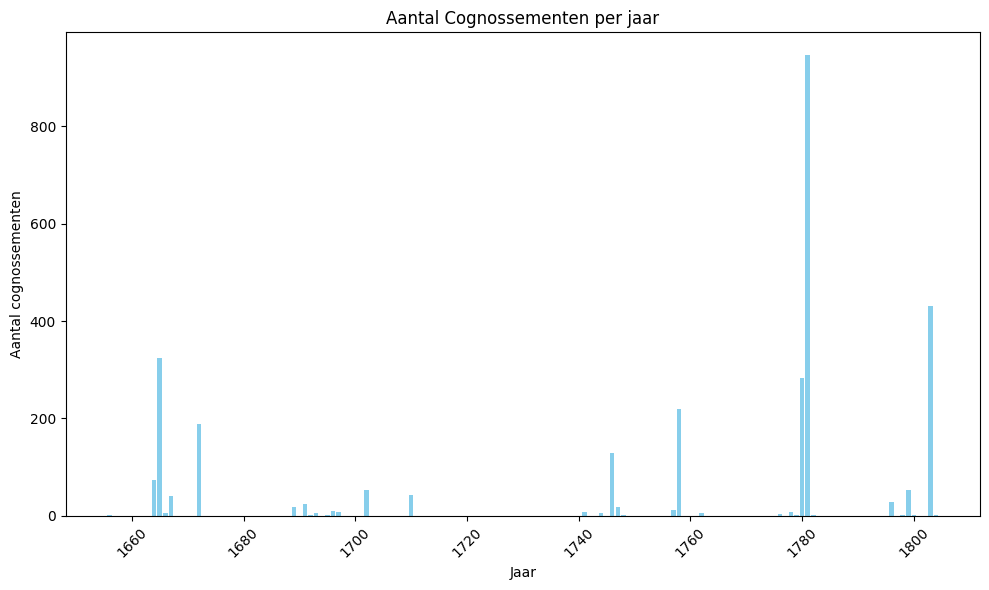

In [8]:
# Plotting the number of cognossementen per year as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(summary_year['year'], summary_year['aantal cognossementen'], color='skyblue')
plt.title('Aantal Cognossementen per jaar')
plt.xlabel('Jaar')
plt.ylabel('Aantal cognossementen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
top_ships_df = summary_ship.sort_values(by='aantal cognossementen', ascending=False).head(20)
print(top_ships_df)

                                            shipNames  aantal cognossementen
5   Anna Maria; Drie Gesusters; Gesina Maria; Jong...                    274
21  Drie Gesusters; Eendragt; Gesina Maria; Goede ...                    252
70                                              Orion                    244
26                                          Eendraght                    166
14                                   Curacaose Visser                    161
55                                      Juffrouw Anna                    118
29  Fort Zeelandia; Bijenkorf; Gekroonde put; Poel...                    115
39                                               Hoop                    114
93                        Zwarte Arend; Westersouburg                    108
67                                Negotie en Zeevaart                     84
65                                          Lust Rust                     81
4   Anna Margaretha; De Attentie; Drie Gesusters; ...                     74

In [10]:
results_df

,transcriptionId,confidence,invNo,year,shipNames
0,30083,10,HCA30-342,1781.0,Drie Gesusters; Gesina Maria; De Hoop; Jonge J...
1,30085,8,HCA30-342,1781.0,Drie Gesusters; Gesina Maria; De Hoop; Jonge J...
2,30115,9,HCA30-342,1781.0,Drie Gesusters; Gesina Maria; De Hoop; Jonge J...
3,30121,10,HCA30-342,1781.0,Drie Gesusters; Gesina Maria; De Hoop; Jonge J...
4,30134,10,HCA30-342,1781.0,Drie Gesusters; Gesina Maria; De Hoop; Jonge J...
...,...,...,...,...,...
2949,94015,6,HCA32-797.28,1799.0,Oldenberg
2950,94016,3,HCA32-797.28,1799.0,Oldenberg
2951,94017,4,HCA32-797.28,1799.0,Oldenberg
2952,94161,7,HCA32-797.33,1800.0,Oster Risoer


Een volgende vraag: hoeveel cognossementen waren er eigenlijk ten opzichte van alle gevonden documenten per jaar? Omdat we individuele documenten niet kunnen onderscheiden (die kunnen meer scans bevatten), kijken we naar de verhouding tussen cognossementen (altijd één scan) en het totaal aan scans per jaar.

In [11]:
# We kiezen alleen jaren waarvoor we gegevens over cognossementen hebben
min_year = int(summary_year['year'].min())
max_year = int(summary_year['year'].max())
all_years = pd.DataFrame({'year': list(range(min_year, max_year + 1))})

# Totaal aantal pagina's per jaar
total_docs = df.groupby('year').size().reset_index(name='total_documents')

# Totaal aantal cognossementen per jaar
cognossement_docs = summary_year.copy()
cognossement_docs['year'] = summary_year['year'].astype(int)

# Samengevoegd geeft dit alle benodigde informatie
merged = pd.merge(all_years, total_docs, on='year', how='left')
merged = pd.merge(merged, cognossement_docs, on='year', how='left')
merged['total_documents'] = merged['total_documents'].fillna(0).astype(int)
merged['aantal cognossementen'] = merged['aantal cognossementen'].fillna(0).astype(int)

# We rekenen het percentage cognossementen uit
merged['percentage'] = merged.apply(
    lambda row: 0 if row['total_documents'] == 0 
                else (row['aantal cognossementen'] / row['total_documents'] * 100), axis=1
)

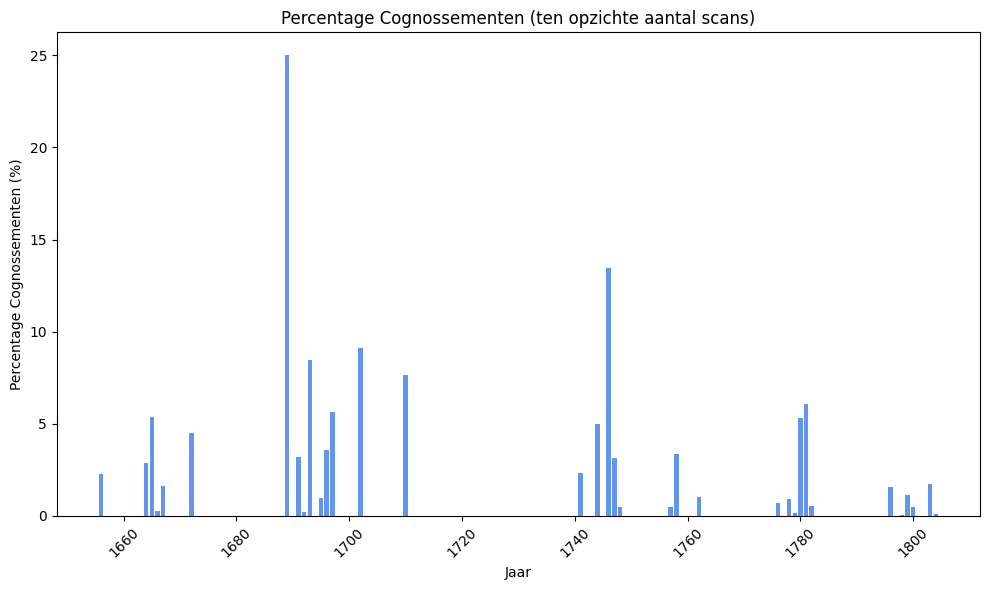

In [13]:
plt.figure(figsize=(10, 6))
plt.bar(merged['year'], merged['percentage'], color='cornflowerblue')
plt.xlabel('Jaar')
plt.ylabel('Percentage Cognossementen (%)')
plt.title('Percentage Cognossementen (ten opzichte aantal scans)')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

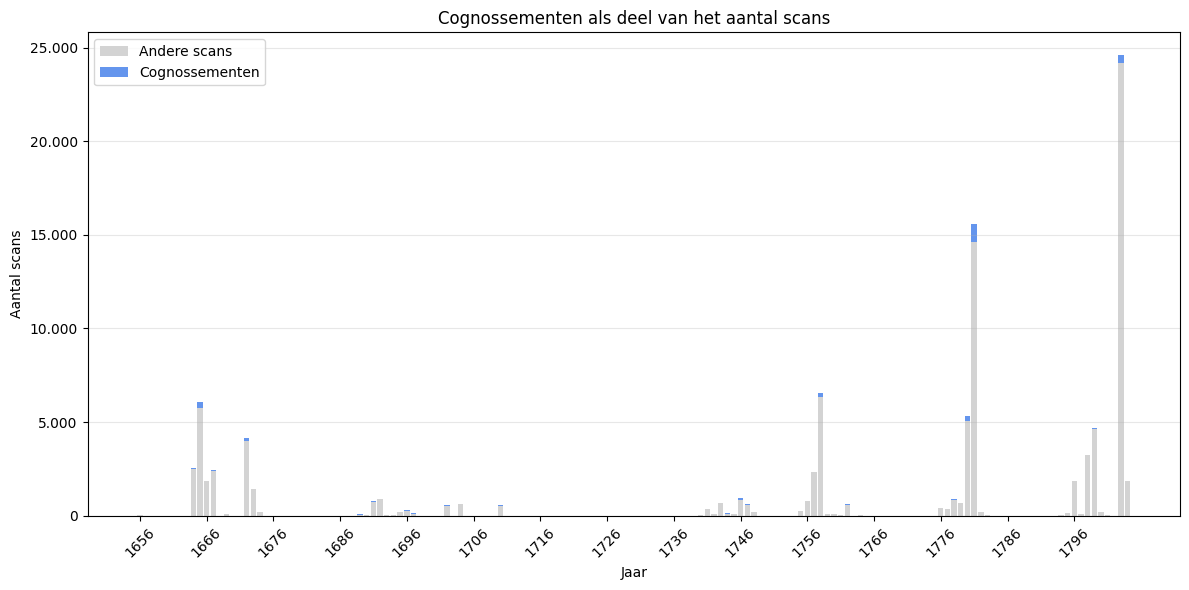

In [43]:
import matplotlib.ticker as mticker  # Voor decimale separators

# We maken een kolom met alle scans waarvan we vermoeden dat het geen cognossementen zijn
merged['other_docs'] = merged['total_documents'] - merged['aantal cognossementen']

x = range(len(merged))

plt.figure(figsize=(12, 6))

# Die geven we apart weer
plt.bar(x, merged['other_docs'], 
        color='lightgray', 
        width=0.8, 
        label='Andere scans')

# Zodat we de cognossementen erboven kunnen weergeven
plt.bar(x, merged['aantal cognossementen'], 
        bottom=merged['other_docs'], 
        color='cornflowerblue', 
        width=0.8, 
        label='Cognossementen')

plt.xlabel('Jaar')
plt.ylabel('Aantal scans')
plt.title('Cognossementen als deel van het aantal scans')
plt.xticks(x[::10], merged['year'][::10], rotation=45)
plt.legend()
plt.gca().get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'.replace(',', '.')))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



Omdat de Dutch Prize Papers vooral stukken bevatten die dateren uit perioden van oorlog tussen Engeland en Nederland, is het logischer om de data daar ook op te sorteren.

In [28]:
def assign_war_label(year):
    """
    Return a war/tension label for the given year based on intervals
    """
    if 1665 <= year <= 1667:
        return "Tweede Engelse Zeeoorlog (1665-1667)"
    elif 1672 <= year <= 1674:
        return "Derde Engelse Zeeoorlog  (1672-1674)"
    elif 1689 <= year <= 1697:
        return "Negenjarige Oorlog (1689-1697)"
    elif 1702 <= year <= 1713:
        return "Spaanse Successieoorlog (1702-1713)"
    elif 1741 <= year <= 1748:
        return "Oostenrijkse Successieoorlog (1741-1748)"
    elif 1756 <= year <= 1763:
        return "Zevenjarige Oorlog (1756-1763)"
    elif 1776 <= year <= 1784:
        return "Amerikaanse Oorlog en Vierde Engelse Zeeoorlog (1776-1784)"
    elif 1795 <= year <= 1804:
        return "Napoleontische Oorlogen (1795-1804)"
    else:
        return "Overige jaren"

In [29]:
# We maken nu een df waarin we de oorlog toevoegen
plot_data = merged.copy()
plot_data['war_label'] = plot_data['year'].apply(assign_war_label)

# .. en vervolgens één waarin we groeperen op oorlogsjaar
grouped = (
    plot_data
    .groupby('war_label', as_index=False)
    .agg({'total_documents': 'sum',
          'aantal cognossementen': 'sum'})
)

grouped['percentage'] = grouped.apply(
    lambda row: 0 if row['total_documents'] == 0
    else (row['aantal cognossementen'] / row['total_documents'] * 100),
    axis=1
)

# We zetten de oorlogen in de juiste volgorde
sort_order = [
    "Tweede Engelse Zeeoorlog (1665-1667)",
    "Derde Engelse Zeeoorlog  (1672-1674)",
    "Negenjarige Oorlog (1689-1697)",
    "Spaanse Successieoorlog (1702-1713)",
    "Oostenrijkse Successieoorlog (1741-1748)",
    "Zevenjarige Oorlog (1756-1763)",
    "Amerikaanse Oorlog en Vierde Engelse Zeeoorlog (1776-1784)",
    "Napoleontische Oorlogen (1795-1804)",
    "Overige jaren"
]

grouped['sort_key'] = grouped['war_label'].apply(lambda x: sort_order.index(x) if x in sort_order else 999)
grouped = grouped.sort_values('sort_key').reset_index(drop=True)
grouped = grouped[['war_label', 'total_documents', 'aantal cognossementen', 'percentage']]

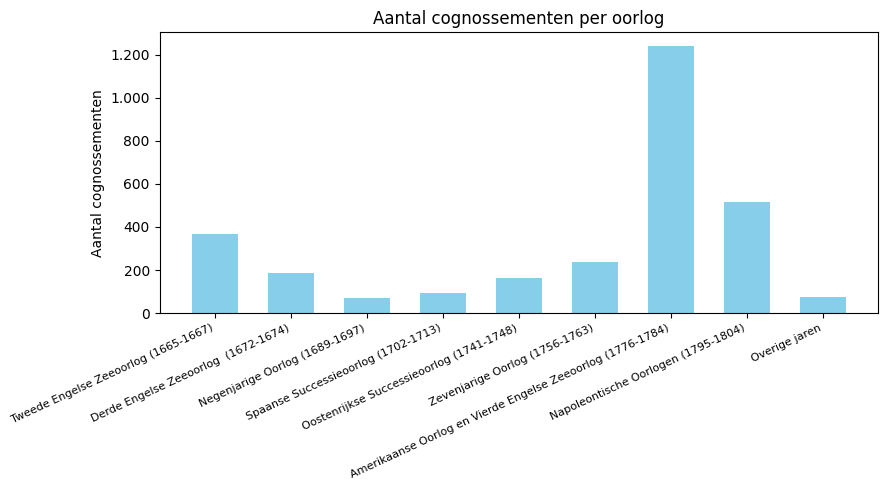

In [45]:
# Aantal cognossementen per oorlog
labels = grouped['war_label']
cog_counts = grouped['aantal cognossementen']

plt.figure(figsize=(9, 5))
plt.bar(labels, cog_counts, color='skyblue', width=0.6)
plt.title('Aantal cognossementen per oorlog')
plt.ylabel('Aantal cognossementen')
plt.xticks(rotation=25, ha='right', fontsize=8) 
plt.gca().get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'.replace(',', '.')))
plt.tight_layout()
plt.show()



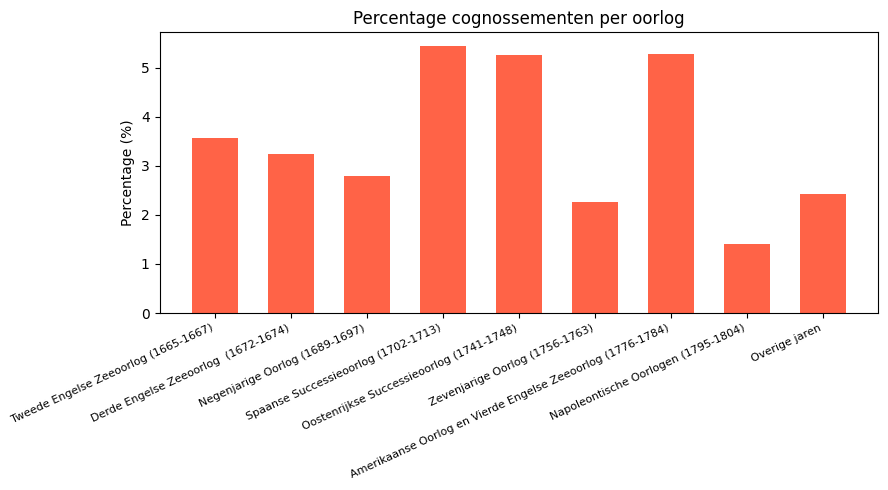

In [46]:
# Percentage cognossementen (/totale aantal scans) per oorlog
pct = grouped['percentage']

plt.figure(figsize=(9, 5))
plt.bar(labels, pct, color='tomato', width=0.6)
plt.title('Percentage cognossementen per oorlog')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=25, ha='right', fontsize=8) 
plt.tight_layout()
plt.show()

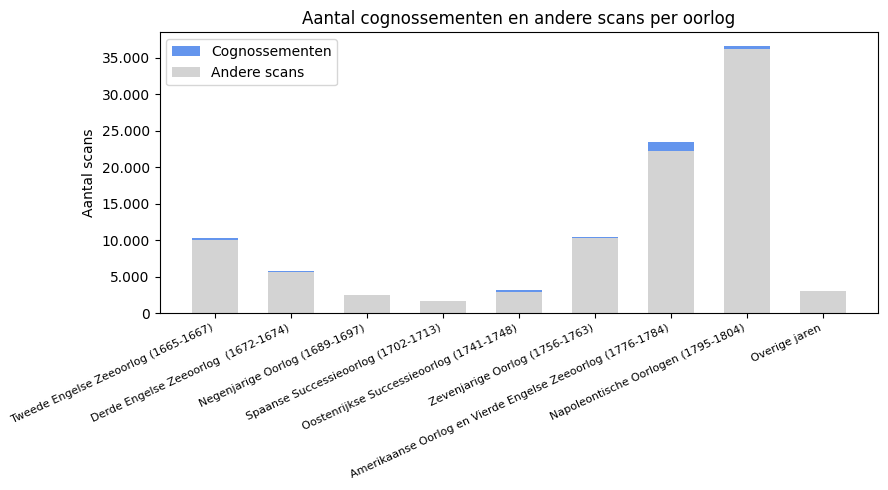

In [47]:
# Totaaloverzicht per oorlog
grouped['other_docs'] = grouped['total_documents'] - grouped['aantal cognossementen']
x = range(len(grouped))

plt.figure(figsize=(9, 5))

# We geven eerst die andere documenten weer
bar_other = plt.bar(x, grouped['other_docs'], 
                    color='lightgray', 
                    width=0.6, 
                    label='Andere scans')

# Zodat we de cognossementen erboven kunnen weergeven
bar_cog = plt.bar(x, grouped['aantal cognossementen'], 
                  bottom=grouped['other_docs'], 
                  color='cornflowerblue', 
                  width=0.6, 
                  label='Cognossementen')

plt.title('Aantal cognossementen en andere scans per oorlog')
plt.ylabel('Aantal scans')
plt.xticks(x, grouped['war_label'], rotation=25, ha='right', fontsize=8)
plt.legend([bar_cog, bar_other], ['Cognossementen', 'Andere scans'])
plt.gca().get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'.replace(',', '.')))

plt.tight_layout()
plt.show()